<a href="https://colab.research.google.com/github/nnajeh/Forecast-Corona-Virus-evolution/blob/master/Predict_Corona_Virus_evolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from keras.utils import np_utils
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [2]:
# Load the updated Corona Virus dataset
!wget https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv

--2020-03-14 22:14:14--  https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62628 (61K) [text/plain]
Saving to: ‘time_series_19-covid-Confirmed.csv’

time_series_19-covi 100%[===================>]  61.16K  --.-KB/s    in 0.008s  

2020-03-14 22:14:14 (7.39 MB/s) - ‘time_series_19-covid-Confirmed.csv’ saved [62628/62628]



In [3]:
# Read the loaded data
dataframe= pd.read_csv('/content/time_series_19-covid-Confirmed.csv')
dataframe.describe()

,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20
count,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.00000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000
mean,33.648870,-38.916934,1.318290,1.551069,2.235154,3.406176,5.030879,6.952494,13.249406,14.646081,19.558195,23.579572,28.593824,39.874109,47.223278,56.750594,65.64133,73.199525,81.688836,88.171021,95.368171,101.572447,106.418052,107.413302,143.391924,158.871734,163.966746,169.178147,174.009501,178.470309,179.665083,180.990499,182.477435,186.648456,187.565321,188.997625,191.004751,193.337292,196.565321,199.809976,204.301663,209.902613,214.503563,220.522565,225.938242,232.498812,241.767221,251.356295,260.795724,269.741093,281.691211,298.966746,304.852732,344.876485
std,17.309566,81.833728,21.691964,21.779313,27.126762,37.768516,52.794900,71.142530,174.400407,175.525661,241.855978,286.759824,352.854569,548.165886,662.620744,816.594028,962.24890,1081.670152,1220.191377,1324.928943,1448.228553,1550.405551,1630.246832,1630.554463,2352.198018,2654.009260,2743.813948,2837.977326,2925.990907,3008.450525,3025.480309,3045.494583,3056.297991,3125.541770,3125.603727,3135.571951,3159.935833,3179.661878,3200.109104,3216.470593,3238.730793,3268.459336,3280.423283,3290.459919,3299.730019,3311.155563,3325.182995,3339.307648,3352.704167,3368.494014,3381.614282,3408.577794,3416.666238,3492.127411
min,-41.454500,-157.858400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,30.791700,-95.814300,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,38.502500,-76.872100,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
75%,42.368900,19.503300,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

In [4]:
# Drop the 4 first columns(Province/State, Country/Region, Lat, Long) because they are not interesting to predict the virus futur
dataframe= dataframe.iloc[:, 4:]
dataframe.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20
0,2,3,5,7,8,8,14,14,14,19,19,19,19,25,25,25,25,32,32,32,33,33,33,33,33,34,35,35,35,35,35,35,35,35,37,40,40,41,42,42,43,43,43,47,48,50,50,50,53,59,70,75
1,2,1,2,2,4,4,7,7,11,15,20,20,20,22,22,45,25,25,26,26,26,28,28,29,43,59,66,74,84,94,105,122,147,159,170,189,214,228,241,256,274,293,331,360,420,461,502,511,581,639,639,701
2,0,1,3,3,4,5,7,7,10,13,16,18,18,24,28,28,30,33,40,45,47,50,58,67,72,75,77,81,84,84,85,85,89,89,91,93,93,93,102,106,108,110,110,117,130,138,150,150,160,178,178,200
3,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,0,0,0,3,4,4,4,7,8,8,8,8,8,10,12,12,12,16,16,18,18,18,19,19,22,22,22,22,22,22,22,22,22,22,22,22,23,23,25,29,29,36,50,50,83,93,99,117,129,149,149,197


In [5]:
# Each row is a daily case of the Corona Virus
# calculate the sum of each row
daily_cases = dataframe.sum(axis=0)
print(daily_cases)

1/22/20       555
1/23/20       653
1/24/20       941
1/25/20      1434
1/26/20      2118
1/27/20      2927
1/28/20      5578
1/29/20      6166
1/30/20      8234
1/31/20      9927
2/1/20      12038
2/2/20      16787
2/3/20      19881
2/4/20      23892
2/5/20      27635
2/6/20      30817
2/7/20      34391
2/8/20      37120
2/9/20      40150
2/10/20     42762
2/11/20     44802
2/12/20     45221
2/13/20     60368
2/14/20     66885
2/15/20     69030
2/16/20     71224
2/17/20     73258
2/18/20     75136
2/19/20     75639
2/20/20     76197
2/21/20     76823
2/22/20     78579
2/23/20     78965
2/24/20     79568
2/25/20     80413
2/26/20     81395
2/27/20     82754
2/28/20     84120
2/29/20     86011
3/1/20      88369
3/2/20      90306
3/3/20      92840
3/4/20      95120
3/5/20      97882
3/6/20     101784
3/7/20     105821
3/8/20     109795
3/9/20     113561
3/10/20    118592
3/11/20    125865
3/12/20    128343
3/13/20    145193
dtype: int64


In [6]:
# Convert "1/22/2020" numbers to a proper date time format "1-22-2020"
daily_cases.index= pd.to_datetime(daily_cases.index)
print(daily_cases)

2020-01-22       555
2020-01-23       653
2020-01-24       941
2020-01-25      1434
2020-01-26      2118
2020-01-27      2927
2020-01-28      5578
2020-01-29      6166
2020-01-30      8234
2020-01-31      9927
2020-02-01     12038
2020-02-02     16787
2020-02-03     19881
2020-02-04     23892
2020-02-05     27635
2020-02-06     30817
2020-02-07     34391
2020-02-08     37120
2020-02-09     40150
2020-02-10     42762
2020-02-11     44802
2020-02-12     45221
2020-02-13     60368
2020-02-14     66885
2020-02-15     69030
2020-02-16     71224
2020-02-17     73258
2020-02-18     75136
2020-02-19     75639
2020-02-20     76197
2020-02-21     76823
2020-02-22     78579
2020-02-23     78965
2020-02-24     79568
2020-02-25     80413
2020-02-26     81395
2020-02-27     82754
2020-02-28     84120
2020-02-29     86011
2020-03-01     88369
2020-03-02     90306
2020-03-03     92840
2020-03-04     95120
2020-03-05     97882
2020-03-06    101784
2020-03-07    105821
2020-03-08    109795
2020-03-09   

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


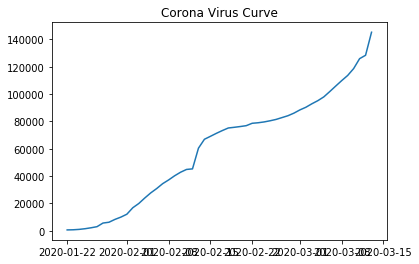

In [7]:
# Show results 
plt.plot(daily_cases, label="Corona Virus Data")
plt.title("Corona Virus Curve")
plt.show()

In [0]:
# Use diff() function to find the discrete difference in the dataframe series compared to another element in the series
# Use fillna() function to fill-out(complete) the missing values in the dataframe series
daily_cases= daily_cases.diff().fillna(daily_cases[0])

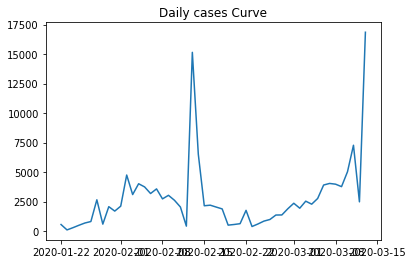

In [9]:
# Show the result
plt.plot(daily_cases, label="Corona Virus Data")
plt.title("Daily cases Curve")
plt.show()

In [10]:
daily_cases.shape

(52,)

In [0]:
#@title Preprocessing



In [0]:
# Split Corona Virus data into train and test sets
test_data_size = 18
train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]

In [0]:
dataset = dataframe.values
dataset = dataset.astype('int64')

In [0]:
# Transform features by scaling each feature to make the data much more faster
# Scale data using only train data
scalar = MinMaxScaler()
scalar = scalar.fit(np.expand_dims(train_data, axis=1))

In [0]:
# Convert the training  data
train_data = scalar.transform(np.expand_dims(train_data, axis=1))
test_data = scalar.transform(np.expand_dims(test_data, axis=1))

In [0]:
# convert an array of values into a dataset matrix
# create a sequence based on the sequence length "seq_length"
# convert sequence to a sub-sequences
def create_seqdata(dataset, seq_length):
  X_data = []
  y_data = []
  for i in range(len(dataset)- seq_length -1):
    seq_in = dataset[i:(i+seq_length)]
    seq_out = dataset[i+seq_length]
    X_data.append(seq_in)
    y_data.append(seq_out)
  return np.array(X_data), np.array(y_data)

In [0]:
#train our model with data from five days
seq_length=8

#split the dataset
X_train, y_train = create_seqdata(train_data, seq_length)
X_test, y_test = create_seqdata(test_data, seq_length)

In [0]:
# convert numpy arrays to PyTorch tensors 
X_train, y_train = torch.from_numpy(X_train).float(),  torch.from_numpy(y_train).float()
X_test, y_test = torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float()

In [0]:
#@title Build the model




In [0]:
class CoronaVirusPediction(nn.Module):
 
  #Define the constructor
  def __init__(self, input_dim, hidden_dim, seq_len, num_layers=2):
    super(CoronaVirusPediction, self).__init__()
    
    self.input_dim= input_dim
    self.hidden_dim= hidden_dim
    # Two LSTM layers
    self.num_layers = num_layers
    self.seq_len= seq_len
    
    # Create the first layer
    self.lstm= nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, dropout=0.5)

    # Create the second(Linear) layer
    # "out_features=1" we will predict just a single number
    self.linear= nn.Linear(in_features=hidden_dim, out_features=1)

    
  # we will use stateless LSTM, so we need to reset the state after each example
  def reset_hidden_state(self):
    self.hidden = (torch.zeros(self.num_layers, self.seq_len, self.hidden_dim), torch.zeros(self.num_layers, self.seq_len, self.hidden_dim))
       
  # get the sequences, pass all of them through the LSTM layer, at once. 
  # We take the output of the last time step and pass it through our linear layer to get the prediction.
  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(sequences.view(len(sequences), self.seq_len, -1), self.hidden)
        
    last_time_step = \
        lstm_out.view(self.seq_len, len(sequences), self.hidden_dim)[-1]

    y_pred = self.linear(last_time_step)

    return y_pred

In [0]:
#@title Train the model

In [0]:
def train_model(model, train_data, train_labels, test_data=None, test_labels=None):

  #construct our loss function
  loss_fn = torch.nn.MSELoss(reduction='sum')

  #Construct our optimize function
  optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
  num_epochs = 60

  # Return a new array with a given shape and type 
  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)

  for t in range(num_epochs):
    model.reset_hidden_state()

    y_pred = model(X_train)

    loss = loss_fn(y_pred.float(), y_train)

    if test_data is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)
      test_hist[t] = test_loss.item()

      if t % 10 == 0:  
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
    elif t % 10 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item()
    
    optimiser.zero_grad()

    loss.backward()

    optimiser.step()
  
  return model.eval(), train_hist, test_hist

In [20]:
# Create the model instance
model = CoronaVirusPediction(input_dim=1, hidden_dim=512, seq_len=seq_length, num_layers=2)
model, train_hist, test_hist = train_model(model, X_train, y_train, X_test, y_test)

Epoch 0 train loss: 1.8993780612945557 test loss: 0.7239571809768677
Epoch 10 train loss: 0.9096190333366394 test loss: 0.14611384272575378
Epoch 20 train loss: 0.9133224487304688 test loss: 0.14846405386924744
Epoch 30 train loss: 0.9235427379608154 test loss: 0.11222799867391586
Epoch 40 train loss: 0.9007084965705872 test loss: 0.12994267046451569
Epoch 50 train loss: 0.879052460193634 test loss: 0.1283426135778427


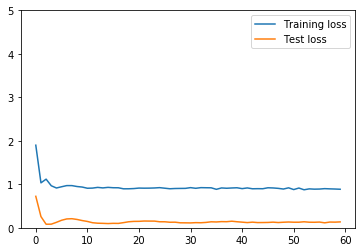

In [21]:
# Show the result
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.ylim((0, 5))
plt.legend();

In [0]:
#@title Predicting daily cases


In [0]:
# predict the next day
with torch.no_grad():
  test_seq = X_test[:1]
  preds = []
  for _ in range(len(X_test)):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [0]:
# Insert a new axis that will appear at the axis position in the expanded array shape.
# invert prediction
true_cases = scalar.inverse_transform(np.expand_dims(y_test.flatten().numpy(), axis=0)).flatten()
predicted_cases = scalar.inverse_transform(np.expand_dims(preds, axis=0)).flatten()

Text(0.5, 1.0, 'Daily cases ')

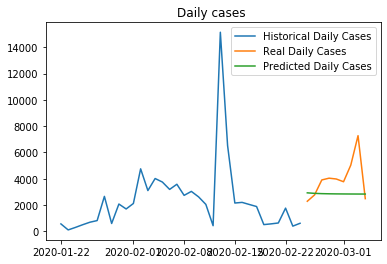

In [24]:
# Show the result
plt.plot(daily_cases.index[:len(train_data)], scalar.inverse_transform(train_data).flatten(), label='Historical Daily Cases')
plt.plot(daily_cases.index[len(train_data):len(train_data) + len(true_cases)], true_cases, label='Real Daily Cases')
plt.plot(daily_cases.index[len(train_data):len(train_data) + len(true_cases)], predicted_cases, label='Predicted Daily Cases')
plt.legend();
plt.title("Daily cases ")

In [0]:
#@title Use all data for training


In [0]:
# Use available data to train the model

scalar = MinMaxScaler()
scalar = scalar.fit(np.expand_dims(daily_cases, axis=1))
all_data = scalar.transform(np.expand_dims(daily_cases, axis=1))

In [27]:
X_all, y_all = create_seqdata(all_data, seq_length)

X_all = torch.from_numpy(X_all).float()
y_all = torch.from_numpy(y_all).float()

model = CoronaVirusPediction( input_dim=1, hidden_dim=512, seq_len=seq_length, num_layers=2)

model, train_hist, _ = train_model(model, X_all, y_all)

Epoch 0 train loss: 2.2887277603149414
Epoch 10 train loss: 0.9209268689155579
Epoch 20 train loss: 0.8973830938339233
Epoch 30 train loss: 0.9063287377357483
Epoch 40 train loss: 0.8888044357299805
Epoch 50 train loss: 0.9098039865493774


In [0]:
#@title Predicting future cases


In [0]:
# We'll use our "fully trained" model to predict the confirmed cases for 12 days into the future:
DAYS_TO_PREDICT = 12

with torch.no_grad():
  test_seq = X_all[:1]
  preds = []
  for _ in range(DAYS_TO_PREDICT):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [0]:
#As before, we'll inverse the scaler transformation:
predicted_cases = scalar.inverse_transform(np.expand_dims(preds, axis=0)).flatten()

In [31]:
daily_cases.index[-1]

Timestamp('2020-03-13 00:00:00')

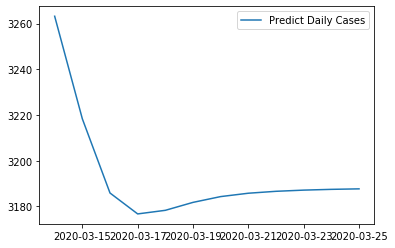

In [32]:
predicted_index = pd.date_range(start=daily_cases.index[-1],periods=DAYS_TO_PREDICT + 1, closed='right')

predicted_cases = pd.Series(data=predicted_cases,  index=predicted_index)

plt.plot(predicted_cases, label='Predict Daily Cases')
plt.legend();

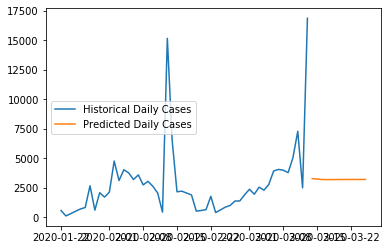

In [33]:
#Now we can use all the data to plot the results:
plt.plot(daily_cases, label='Historical Daily Cases')
plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();